Please upload multiple images for detection (you can select multiple files):


Saving 0099airplane.png to 0099airplane.png
Saving 0006do.png to 0006do.png
Saving 006ca.png to 006ca.png
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 181s 225ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step

Processing 0099airplane.png...


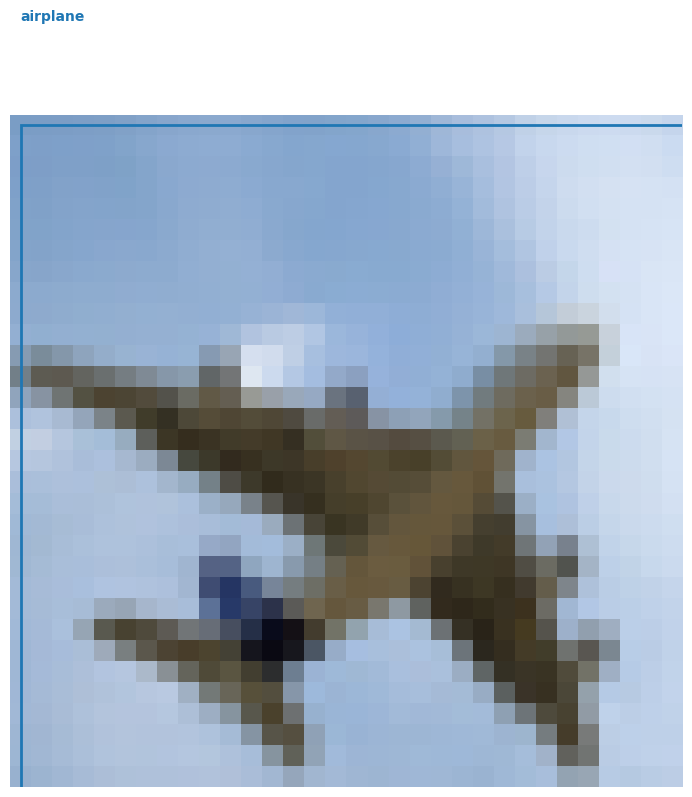

Detected classes in 0099airplane.png: ['airplane']

Processing 0006do.png...


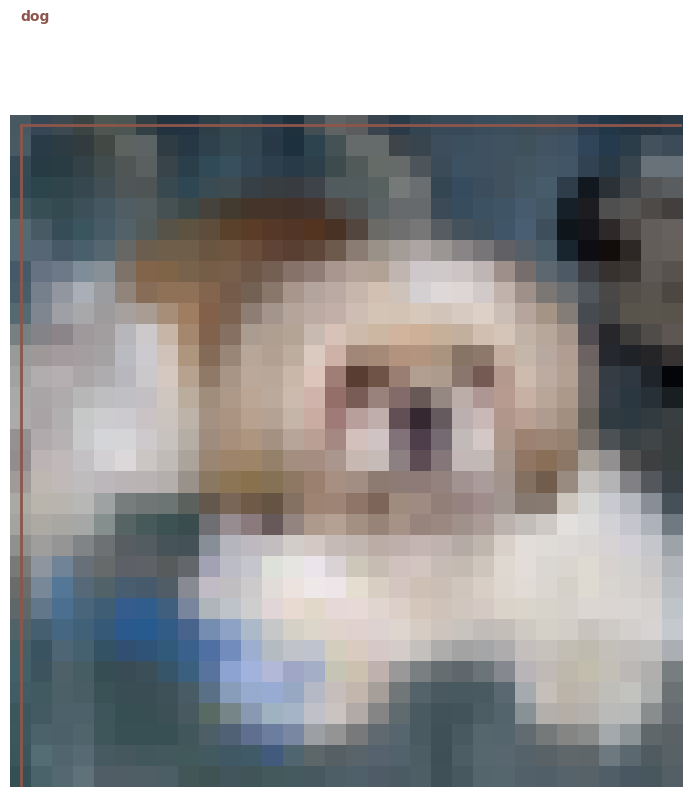

Detected classes in 0006do.png: ['dog']

Processing 006ca.png...


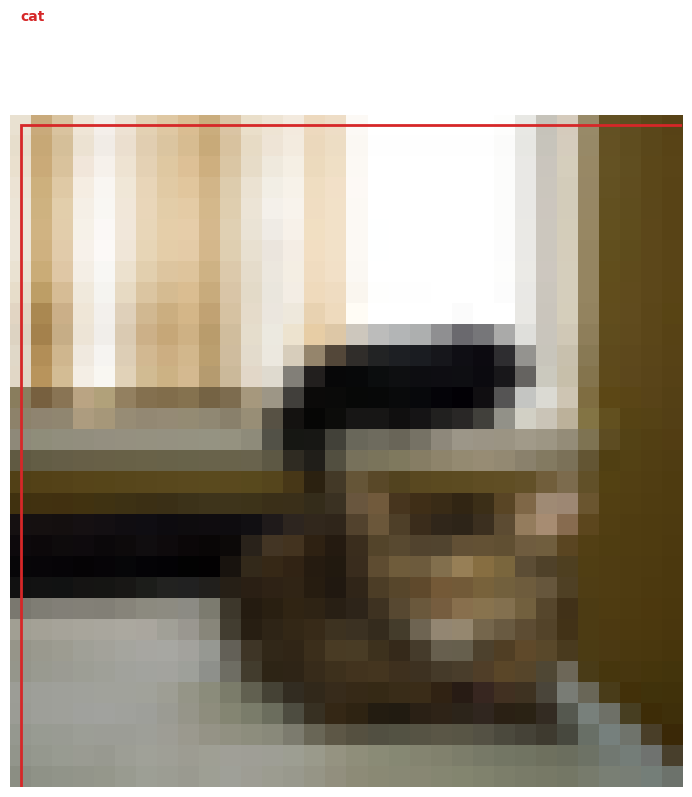

Detected classes in 006ca.png: ['cat']


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CLASS_COLORS = plt.cm.tab10(np.linspace(0, 1, len(CLASS_NAMES)))

def load_feature_extractor():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    return Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

def train_classifier():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
    feature_extractor = load_feature_extractor()
    x_train_features = feature_extractor.predict(x_train, batch_size=64)
    x_test_features = feature_extractor.predict(x_test, batch_size=64)
    y_train, y_test = y_train.flatten(), y_test.flatten()
    knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
    knn.fit(x_train_features, y_train)
    return knn, feature_extractor

def generate_sliding_windows(image, window_size=(32, 32), stride=16):
    patches, locations = [], []
    h, w = image.shape[:2]
    for y in range(0, h - window_size[0] + 1, stride):
        for x in range(0, w - window_size[1] + 1, stride):
            patch = image[y:y+window_size[0], x:x+window_size[1]]
            patch = cv2.resize(patch, (32, 32)).astype('float32') / 255.0
            patches.append(np.expand_dims(patch, axis=0))
            locations.append((x, y, window_size[0], window_size[1]))
    return np.vstack(patches), locations

def non_max_suppression(boxes, scores, iou_threshold=0.3):
    sorted_idx = np.argsort(scores)[::-1]
    keep = []
    while sorted_idx.size > 0:
        i = sorted_idx[0]
        keep.append(i)
        overlap = compute_iou(boxes[i], boxes[sorted_idx[1:]])
        sorted_idx = sorted_idx[np.where(overlap <= iou_threshold)[0] + 1]
    return keep

def compute_iou(box, other_boxes):
    x1, y1, w1, h1 = box
    x1_end, y1_end = x1 + w1, y1 + h1
    x2s, y2s = other_boxes[:, 0], other_boxes[:, 1]
    w2s, h2s = other_boxes[:, 2], other_boxes[:, 3]
    x2_ends, y2_ends = x2s + w2s, y2s + h2s
    x_left = np.maximum(x1, x2s)
    y_top = np.maximum(y1, y2s)
    x_right = np.minimum(x1_end, x2_ends)
    y_bottom = np.minimum(y1_end, y2_ends)
    intersection = np.maximum(0, x_right - x_left) * np.maximum(0, y_bottom - y_top)
    box_area = w1 * h1
    other_areas = w2s * h2s
    union = box_area + other_areas - intersection
    return intersection / union

def detect_objects_in_image(image_path, knn, feature_extractor):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    patches, locations = generate_sliding_windows(image_rgb)
    patch_features = feature_extractor.predict(patches, verbose=0)
    preds = knn.predict(patch_features)
    confidences = knn.predict_proba(patch_features)
    valid_mask = confidences.max(axis=1) > 0.5
    valid_preds, valid_locs = preds[valid_mask], np.array(locations)[valid_mask]
    nms_idx = non_max_suppression(valid_locs, confidences[valid_mask].max(axis=1))
    final_preds, final_locs = valid_preds[nms_idx], valid_locs[nms_idx]

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    for pred, loc in zip(final_preds, final_locs):
        x, y, w, h = loc
        color = CLASS_COLORS[pred]
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor=color, linewidth=2))
        plt.text(x, y-5, CLASS_NAMES[pred], color=color, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return [CLASS_NAMES[i] for i in final_preds]

def process_multiple_images():
    print("Please upload multiple images for detection (you can select multiple files):")
    uploaded = files.upload()

    # Train the classifier once for all images
    knn, feature_extractor = train_classifier()

    # Process each uploaded image
    results = {}
    for image_name, image_data in uploaded.items():
        print(f"\nProcessing {image_name}...")
        with open(image_name, 'wb') as f:
            f.write(image_data)

        detected_objects = detect_objects_in_image(image_name, knn, feature_extractor)
        results[image_name] = detected_objects
        print(f"Detected classes in {image_name}:", detected_objects)

    return results

# Run the detection on multiple images
results = process_multiple_images()